### 2.Проаналізувати завантажений датасет, провести підготовку для роботу із ним (форматування, видалення пустих значень тощо).


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


In [6]:
# Відкриваємо файл і читаємо вміст, замінюємо всі коми на крапки з комою та записуємо у новий файл
with open("saveecobot_19116.csv", "r", encoding="utf-8") as f:
    data = f.read()

data = data.replace(",", ";")

with open("file_updated.csv", "w", encoding="utf-8") as f:
    f.write(data)


In [7]:
# Фільтруємо тільки 2022 рік
df = pd.read_csv("file_updated.csv", sep=";")

df["logged_at"] = pd.to_datetime(df["logged_at"], dayfirst=True, errors="coerce")

df_2022 = df[df["logged_at"].dt.year == 2022]

df_2022.to_csv("data_2022.csv", index=False, sep=";")


C:\Users\angel\AppData\Local\Temp\ipykernel_19256\1071361279.py:4: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["logged_at"] = pd.to_datetime(df["logged_at"], dayfirst=True, errors="coerce")


In [8]:
df = pd.read_csv("data_2022.csv", sep=";")

# Перетворюємо logged_at у формат дати
df["logged_at"] = pd.to_datetime(df["logged_at"], dayfirst=True, errors="coerce")

# Видаляємо рядки з пустими значеннями
df = df.dropna()
df = df.reset_index(drop=True)

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   device_id   0 non-null      int64         
 1   phenomenon  0 non-null      object        
 2   value       0 non-null      float64       
 3   logged_at   0 non-null      datetime64[ns]
 4   value_text  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 132.0+ bytes
None
Empty DataFrame
Columns: [device_id, phenomenon, value, logged_at, value_text]
Index: []


----------------------

### 3.Знайти можливі залежності між забруднювачами повітря (чи залежить забруднювач PM2.5 від чадного газу і тд). Зробити це з використанням регресійного аналізу. Отримати показники залежностей (або показати, що такі залежності відсутні). 

pip install statsmodels


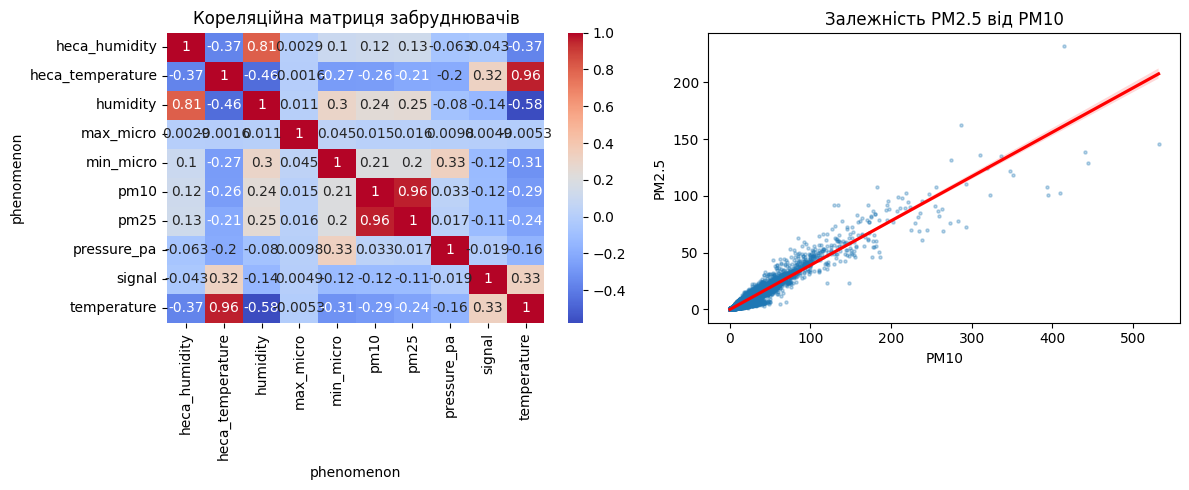

In [9]:
df = pd.read_csv("data_2022.csv", sep=";")
pivot = df.pivot_table(index="logged_at", columns="phenomenon", values="value", aggfunc="mean")
pivot = pivot.dropna()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(pivot.corr(), annot=True, cmap="coolwarm")
plt.title("Кореляційна матриця забруднювачів")

X = sm.add_constant(pivot["pm10"])
y = pivot["pm25"]
model = sm.OLS(y, X).fit()

plt.subplot(1, 2, 2)
sns.regplot(x=pivot["pm10"], y=pivot["pm25"],
            scatter_kws={"s": 5, "alpha": 0.3},
            line_kws={"color": "red"})
plt.title("Залежність PM2.5 від PM10")
plt.xlabel("PM10")
plt.ylabel("PM2.5")

plt.tight_layout()
plt.show()


Висновок:
<p>Після аналізу даних видно, що показники PM10 і PM2.5 дуже сильно пов’язані між собою – якщо зростає один, то зростає й інший. Це означає, що вони походять від одних і тих самих джерел забруднення, і за значенням PM10 можна досить точно передбачити PM2.5. Температура, виміряна різними датчиками, теж добре співпадає, що підтверджує правильність їх роботи. Крім того, помітно, що зі зростанням температури вологість зменшується – це природне явище. Інші параметри (наприклад, тиск чи сигнал) майже не впливають на рівень забруднення. Отже, головний висновок – основними показниками забруднення є саме PM10 і PM2.5, і вони дуже тісно пов’язані між собою.<\p>

--------------------

### 4.Отримати регресійну модель залежності, використавши частину набору даних на навчання, іншу частину – на тестування моделі
a)Залежність забрудника від часу дня (зранку повітря брудніше ніж вночі – це припущення. Обгрунтувати або спростувати його).


Аналіз для pm10 ----------------------------------------------
MSE: 106.0382
R^2: 0.0028


c:\Users\angel\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


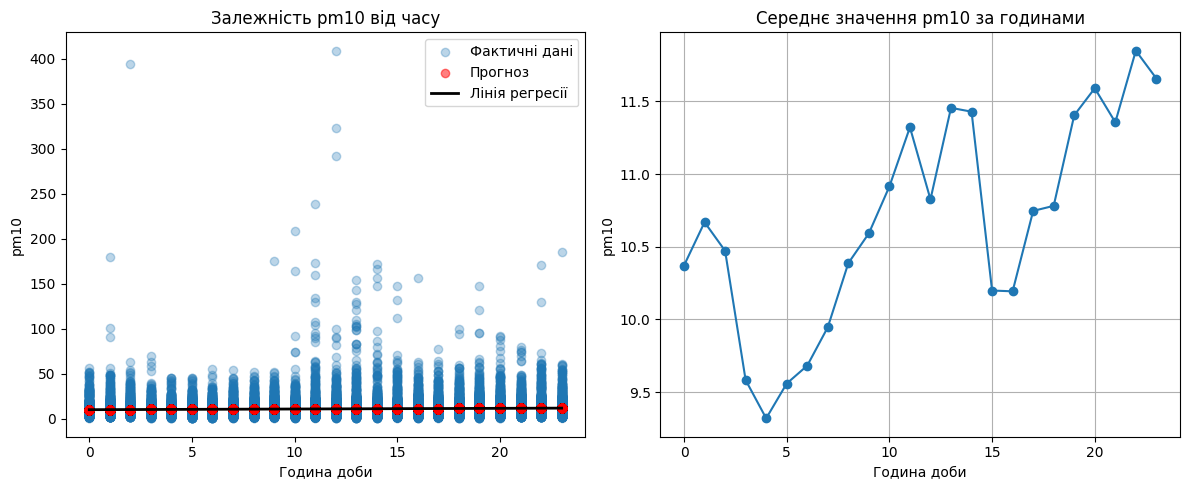

In [ ]:
df = pd.read_csv("data_2022.csv", sep=";")
df["logged_at"] = pd.to_datetime(df["logged_at"])
df["hour"] = df["logged_at"].dt.hour
pollutant = "pm10"
df_sub = df[df["phenomenon"] == pollutant]
X = df_sub[["hour"]]
y = df_sub["value"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Аналіз для {pollutant} ----------------------------------------------")
print(f"MSE: {mse:.4f}")
print(f"R^2: {r2:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_test, y_test, alpha=0.3, label="Фактичні дані")
plt.scatter(X_test, y_pred, color="red", alpha=0.5, label="Прогноз")
plt.plot(range(24), model.predict(np.arange(24).reshape(-1, 1)), color="black", linewidth=2, label="Лінія регресії")
plt.xlabel("Година доби")
plt.ylabel(pollutant)
plt.title(f"Залежність {pollutant} від часу")
plt.legend()

hourly_avg = df_sub.groupby("hour")["value"].mean()

plt.subplot(1, 2, 2)
plt.plot(hourly_avg.index, hourly_avg.values, marker="o")
plt.xlabel("Година доби")
plt.ylabel(pollutant)
plt.title(f"Середнє значення {pollutant} за годинами")
plt.grid(True)

plt.tight_layout()
plt.show()


Висновок:

<p>Концентрація PM10 не має чіткої залежності від часу доби, тому проста регресійна модель погано підходить для прогнозування (R² ≈ 0). Водночас, середні значення показують певну закономірність: вночі повітря чистіше, а ввечері рівень забруднення зростає. Це може бути пов’язано з тим, що ввечері зростає активність транспорту та використання енергії.</p >

б)Залежність одного забрудника від іншого

Коефіцієнт регресії: 2.3418428927414516
Вільний член: 1.1067641666380386
R²: 0.9112942291927493
MSE: 9.061083971148793


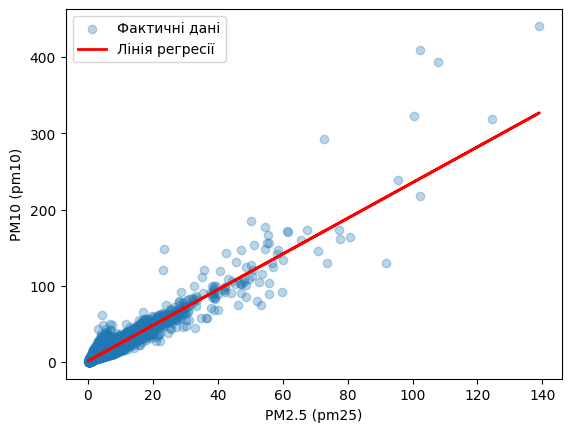

In [11]:
df = pd.read_csv("data_2022.csv", sep=";")

# Pivot: кожен момент часу = рядок, забрудники = колонки
pivot = df.pivot_table(
    index="logged_at", 
    columns="phenomenon", 
    values="value", 
    aggfunc="mean"
)

pivot = pivot.dropna(subset=["pm10", "pm25"])

X = pivot[["pm25"]]  
y = pivot["pm10"]   

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Лінійна регресія
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Коефіцієнт регресії:", model.coef_[0])
print("Вільний член:", model.intercept_)
print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

plt.scatter(X_test, y_test, alpha=0.3, label="Фактичні дані")
plt.plot(X_test, y_pred, color="red", linewidth=2, label="Лінія регресії")
plt.xlabel("PM2.5 (pm25)")
plt.ylabel("PM10 (pm10)")
plt.legend()
plt.show()


Висновки та припущення:
<p>Існує сильна залежність між PM2.5 та PM10. Якщо ми знаємо рівень PM2.5, то можемо досить точно передбачити PM10. Можна припустити, що обидва ці показники пов’язані з одними й тими ж джерелами забруднення (наприклад, транспорт, промисловість).</p>

---

### 5.Отримати чисельні оцінки (RMSE, R^2) отриманої моделі.

RMSE: 3.144478986072644
R^2: 0.9062915174184808


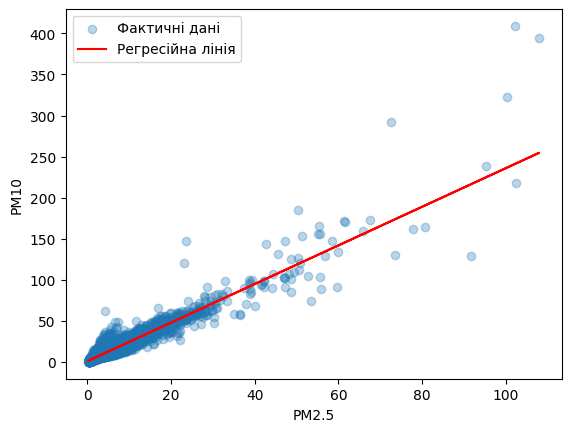

In [12]:
df = pd.read_csv("data_2022.csv", sep=";")

df_pm10 = df[df["phenomenon"] == "pm10"][["logged_at", "value"]].rename(columns={"value": "pm10"})
df_pm25 = df[df["phenomenon"] == "pm25"][ ["logged_at", "value"] ].rename(columns={"value": "pm25"})

# Об'єднуємо по часу
df_merged = pd.merge(df_pm10, df_pm25, on="logged_at")

X = df_merged[["pm25"]]
y = df_merged["pm10"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Лінійна регресія
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Метрики
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("RMSE:", rmse)
print("R^2:", r2)

plt.scatter(X_test, y_test, alpha=0.3, label="Фактичні дані")
plt.plot(X_test, y_pred, color="red", label="Регресійна лінія")
plt.xlabel("PM2.5")
plt.ylabel("PM10")
plt.legend()
plt.show()

ВисновоК:
<p>Модель показує дуже хороший результат. Значення R² ≈ 0.91 говорить про те, що близько 91% змін у PM10 пояснюється змінами в PM2.5. Це свідчить про сильний зв’язок між цими двома показниками. Помилка моделі (RMSE ≈ 3.14) є невеликою, тобто прогнозовані значення досить близькі до реальних.</p>

----